In [1]:
import os
import numpy as np
import keras
from keras.applications import ResNet50V2
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import optimizers
import matplotlib.pyplot as plt
import cv2
from keras.layers import Dropout
from tensorflow.keras import backend as K
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import csv
import pandas as pd

Using TensorFlow backend.
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu

In [2]:
base_dir = r'D:\dataset\dental\data'

data = np.load(base_dir + '\\data_KNU_Diorco_so_imgs.npy')
label_csv= open(base_dir + '\\data_KNU_Diorco_so_img_labels.csv', 'r')
label = csv.reader(label_csv)

right_label = np.load(base_dir + '\\right_label.npy')
left_label = np.load(base_dir + '\\left_label.npy')

right = data[:,:,:, 0:3]
left = data[:,:,:, 3:7]

patient_data = []
patient_data.extend(left)
patient_data.extend(right)
patient_data = np.array(patient_data)

patient_labels = []
patient_labels.extend(left_label)
patient_labels.extend(right_label)
patient_labels = np.array(patient_labels)

train_data, test_data, train_label, test_label= train_test_split(patient_data, patient_labels, test_size = 0.2, random_state = 33, shuffle = True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.2, random_state = 33, shuffle = True)

train_data = train_data.astype(np.float32) / 127.5 - 1
test_data = test_data.astype(np.float32) / 127.5 - 1
val_data = val_data.astype(np.float32) / 127.5 - 1

model = models.load_model('real3_dental_ResNet50V2_3.h5')
model.load_weights('real3_dental_ResNet50V2_3.h5')



In [3]:
x = np.expand_dims(train_data[0], axis=0)

In [4]:
preds = model.predict(x)

In [5]:
preds

array([[0.71052134, 0.09314229, 0.19633636]], dtype=float32)

In [11]:
last_conv_layer_name = 'conv5_block3_3_conv'
classifier_layer_names = [
    "global_average_pooling2d_1",
    "dense_1",
    "dense_2"
]

In [19]:
normal_output = model.output
last_conv_layer = model.layers[0].get_layer('conv5_block3_3_conv')
loss = K.mean(last_conv_layer.output[:, :, :, 1])


grads = K.gradients(loss, last_conv_layer.output)[0]

In [20]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([last_conv_layer.output], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate(x)

for i in range(len(pooled_grads_value)-1):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]


heatmap = np.mean(conv_layer_output_value, axis=-1)

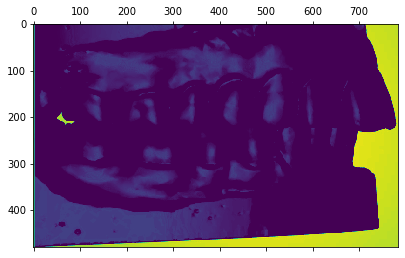

In [21]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [19]:
model.layers[0].summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 784, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 486, 790, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 240, 392, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 242, 394, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [12]:
normal_output = model.output[:, 1]
last_conv_layer = model.layers[0].get_layer('conv5_block3_3_conv')

grads = K.gradients(normal_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

# 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구합니다
iterate = K.function([last_conv_layer.output], [pooled_grads, last_conv_layer.output[0]])

# 두 마리 코끼리가 있는 샘플 이미지를 주입하고 두 개의 넘파이 배열을 얻습니다
pooled_grads_value, conv_layer_output_value = iterate(x)

# "아프리카 코끼리" 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱합니다
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵입니다
heatmap = np.mean(conv_layer_output_value, axis=-1)

AttributeError: 'NoneType' object has no attribute 'dtype'